In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

In [2]:
# Define global constants
global kB 
kB = 1.380649 * 10**-23    # Boltzmann
global h
h = 6.62607 * 10**-34      # Planck
global R
R = 1.9858775 * 10**-3     # universal gas (kcal / mol / K)

In [3]:
def membrane_barriers(lam, dGm, T=300):
    '''Calculate membrane transport contribution to permeability from distribution of jump lengths and barriers'''
    return np.sum( np.exp(dGm / R / T) / lam ) # units 1/length



def interfacial_barriers(dG_sm, dG_ms, lam_sm=2, lam_ms=2, T=300):
    '''Calculate membrane partitioning contribution to permeability from interfacial barriers'''
    return (lam_sm/lam_ms) * (kB*T/h) * np.exp((dG_ms - dG_sm) / R / T) # units 1/s


def calculate_permeability(dG_m, lam, dG_sm, dG_ms, lam_sm=2, lam_ms=2, T=300):
    '''Calculate permeability from membrane barriers'''
    num = interfacial_barriers(dG_sm, dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)
    den = membrane_barriers(lam, dG_m, T=T)
    return num / den * (10**9)**3 / 10**-3 * 60 * 60
    
        
def calculate_dH_dS(P, T, delta, lam, plot=False):
    '''Calculate the enthalpy and entropy from permeabilities measured over temperature'''
    Y = np.log(P*h*delta / (kB*T*lam**2))
    X = 1 / T        
    m, b = np.polyfit(X,Y,1)
    if plot:
        x = np.linspace(X[0], X[-1], num=50)
        plt.scatter(X,Y)
        plt.plot(x, m*x+b)
        plt.xlabel('1/T')
        plt.ylabel('ln($P h \delta$ / $k_B T \lambda$)')
        
    dH = -m*R
    dS = b*R
    display(Latex('$\Delta H$ = {:.4f}, $\Delta S$ = {:.4f}'.format(dH, dS)))
    return dH, dS

In [4]:
dG_large_mem = 30 # large membrane barrier
dG_small_mem = 15 # small membrane barrier

lam_large = 4 # (nm) large jump length
lam_small = 0.25 # (nm) small jump length

sigma_large = 10 # large stdev
sigma_small = 1 # small stdev

## How does a distribution of membrane barriers affect permeability, enthalpy, and entropy?
- Equal jump lengths
- Interfacial barriers not changing
- Temperatures = [250, 275, 300, 325, 350] K

In [5]:
# Input jump info
n_jumps = 200 # number of jumbers in the direction of transport
lam_avg = 2 # average jump length (nm)
lam = np.ones(n_jumps)*lam_avg
delta = lam.sum()
print('Membrane thickness: {:.1f} nm'.format(delta))

# Input interface barriers
dG_sm = 35
dG_ms = 2
lam_sm = 2
lam_ms = 2

# Input temperatures
temps = np.array([250, 275, 300, 325, 350]) # K

# Input iterations
n_iter = 5000

Membrane thickness: 400.0 nm


#### Many equal barriers (large)

<IPython.core.display.Latex object>

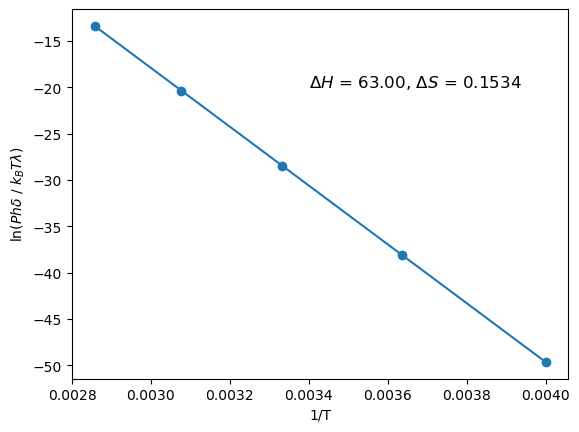

In [12]:
def get_barriers(dG, n_jumps):
    '''Many equal barriers'''
    dG_m = np.ones(n_jumps)*dG
    return dG_m


P = np.zeros(len(temps))
for t in range(len(temps)):
    T = temps[t]
    dG_m = get_barriers(dG_large_mem, n_jumps)
    P[t] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)

P_dist = np.zeros(n_iter)
for n in range(n_iter):
    dG_m = get_barriers(dG_large_mem, n_jumps)
    P_dist[n] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=300)
    
dH, dS = calculate_dH_dS(P, temps, delta=delta, lam=lam_avg, plot=True)
plt.text(0.0034, -20, '$\Delta H$ = {:.2f}, $\Delta S$ = {:.4f}'.format(dH, dS), size=12);
    
# fig = plt.figure()
# display(Latex('Average P at T=300 K : {:.4e} $L m^{{-2}} h^{{-2}}$'.format(P_dist.mean())))
# hist = plt.hist(np.log(P_dist), bins=50, density=True)
# plt.xlabel('ln(permeability $L m^{-2} h^{-2}$)')
# plt.ylabel('probability');

#### Many equal barriers (small), equal jump lengths

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

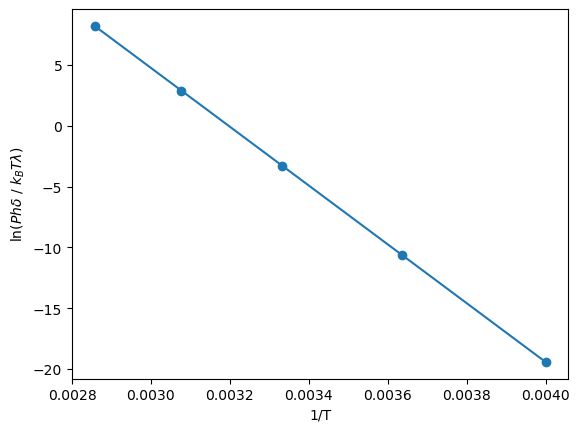

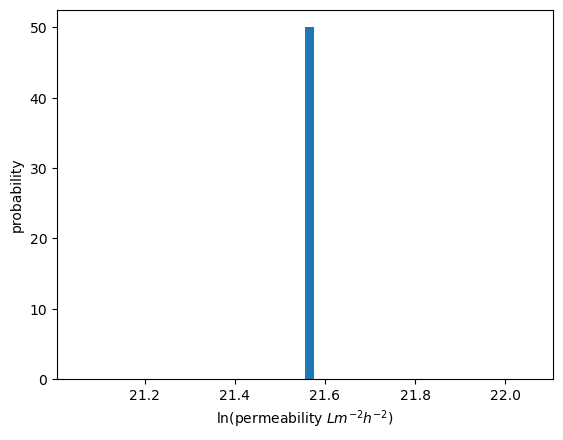

In [197]:
def get_barriers(dG, n_jumps):
    '''Many equal barriers'''
    dG_m = np.ones(n_jumps)*dG
    return dG_m


P = np.zeros(len(temps))
for t in range(len(temps)):
    T = temps[t]
    dG_m = get_barriers(dG_small_mem, n_jumps)
    P[t] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)

P_dist = np.zeros(n_iter)
for n in range(n_iter):
    dG_m = get_barriers(dG_small_mem, n_jumps)
    P_dist[n] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=300)
    
dH, dS = calculate_dH_dS(P, temps, delta=delta, lam=lam_avg, plot=True)
    
fig = plt.figure()
display(Latex('Average P at T=300 K : {:.4e} $L m^{{-2}} h^{{-2}}$'.format(P_dist.mean())))
hist = plt.hist(np.log(P_dist), bins=50, density=True)
plt.xlabel('ln(permeability $L m^{-2} h^{-2}$)')
plt.ylabel('probability');

#### Normal distribution (large-large)

<IPython.core.display.Latex object>

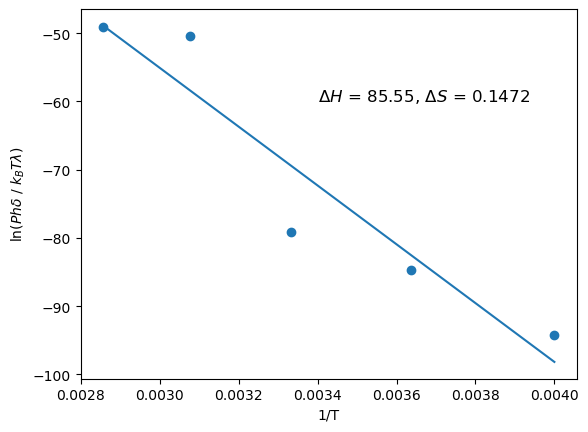

In [13]:
def get_barriers(dG_mu, dG_sig, n_jumps):
    '''Normal distribution of barriers'''
    rng = np.random.default_rng()
    dG_m = rng.normal(loc=dG_mu, scale=dG_sig, size=n_jumps)
    return dG_m


P = np.zeros(len(temps))
for t in range(len(temps)):
    T = temps[t]
    dG_m = get_barriers(dG_large_mem, sigma_large, n_jumps)
    P[t] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)

P_dist = np.zeros(n_iter)
for n in range(n_iter):
    dG_m = get_barriers(dG_large_mem, sigma_large, n_jumps)
    P_dist[n] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=300)
    
dH, dS = calculate_dH_dS(P, temps, delta=delta, lam=lam_avg, plot=True)
plt.text(0.0034, -60, '$\Delta H$ = {:.2f}, $\Delta S$ = {:.4f}'.format(dH, dS), size=12);


# fig = plt.figure()
# display(Latex('Average P at T=300 K : {:.4e} $L m^{{-2}} h^{{-2}}$'.format(P_dist.mean())))
# hist = plt.hist(np.log(P_dist), bins=50, density=True)
# plt.xlabel('ln(permeability $L m^{-2} h^{-2}$)')
# plt.ylabel('probability');

#### Normal distribution (small,large)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

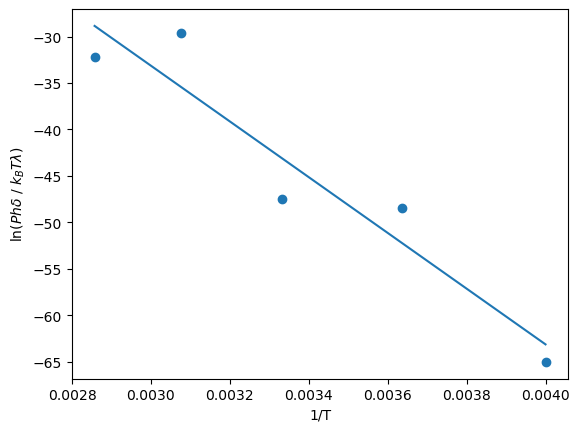

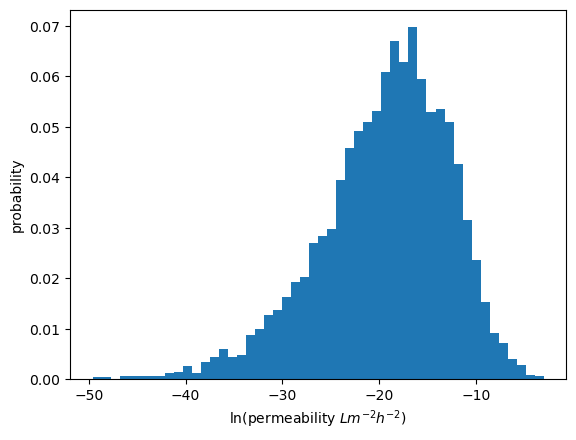

In [200]:
def get_barriers(dG_mu, dG_sig, n_jumps):
    '''Normal distribution of barriers'''
    rng = np.random.default_rng()
    dG_m = rng.normal(loc=dG_mu, scale=dG_sig, size=n_jumps)
    return dG_m


P = np.zeros(len(temps))
for t in range(len(temps)):
    T = temps[t]
    dG_m = get_barriers(dG_small_mem, sigma_large, n_jumps)
    P[t] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)

P_dist = np.zeros(n_iter)
for n in range(n_iter):
    dG_m = get_barriers(dG_small_mem, sigma_large, n_jumps)
    P_dist[n] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=300)
    
    
dH, dS = calculate_dH_dS(P, temps, delta=delta, lam=lam_avg, plot=True)

fig = plt.figure()
display(Latex('Average P at T=300 K : {:.4e} $L m^{{-2}} h^{{-2}}$'.format(P_dist.mean())))
hist = plt.hist(np.log(P_dist), bins=50, density=True)
plt.xlabel('ln(permeability $L m^{-2} h^{-2}$)')
plt.ylabel('probability');

#### Normal distribution, (large,small)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

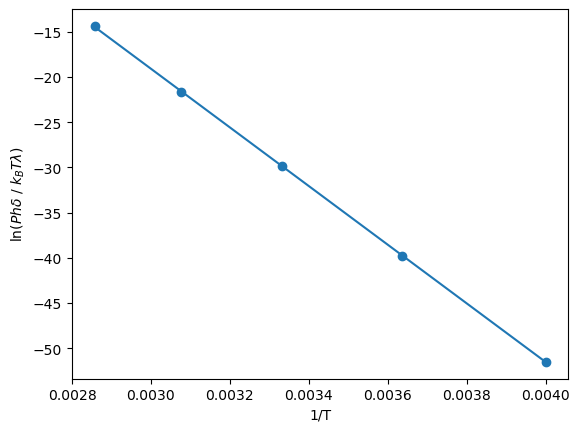

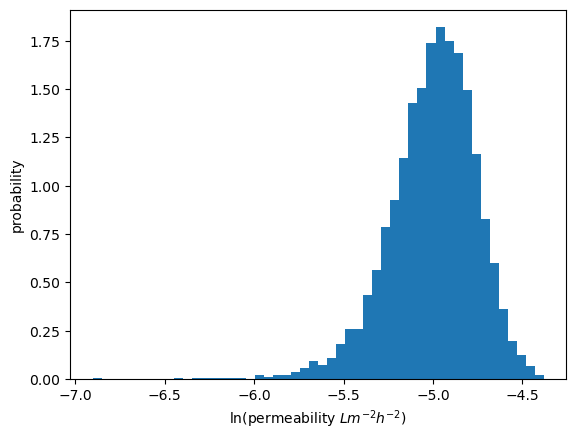

In [201]:
def get_barriers(dG_mu, dG_sig, n_jumps):
    '''Normal distribution of barriers'''
    rng = np.random.default_rng()
    dG_m = rng.normal(loc=dG_mu, scale=dG_sig, size=n_jumps)
    return dG_m


P = np.zeros(len(temps))
for t in range(len(temps)):
    T = temps[t]
    dG_m = get_barriers(dG_large_mem, sigma_small, n_jumps)
    P[t] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)

P_dist = np.zeros(n_iter)
for n in range(n_iter):
    dG_m = get_barriers(dG_large_mem, sigma_small, n_jumps)
    P_dist[n] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=300)

dH, dS = calculate_dH_dS(P, temps, delta=delta, lam=lam_avg, plot=True)

fig = plt.figure()
display(Latex('Average P at T=300 K : {:.4e} $L m^{{-2}} h^{{-2}}$'.format(P_dist.mean())))
hist = plt.hist(np.log(P_dist), bins=50, density=True)
plt.xlabel('ln(permeability $L m^{-2} h^{-2}$)')
plt.ylabel('probability');

#### Normal distribution, (small, small)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

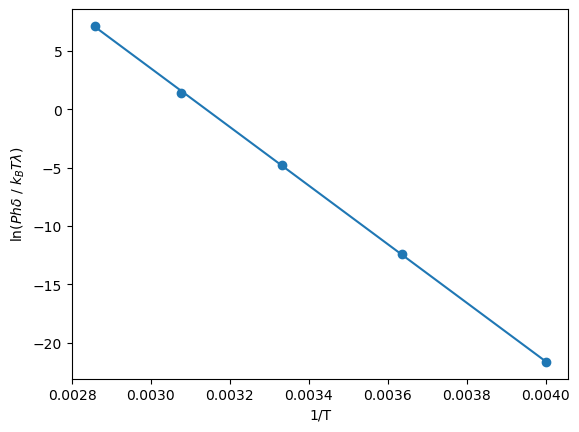

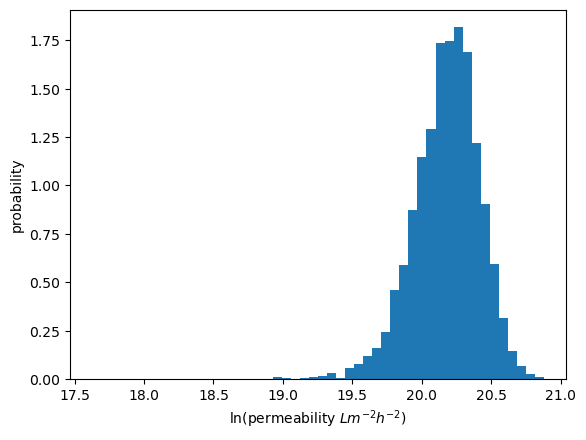

In [202]:
def get_barriers(dG_mu, dG_sig, n_jumps):
    '''Normal distribution of barriers'''
    rng = np.random.default_rng()
    dG_m = rng.normal(loc=dG_mu, scale=dG_sig, size=n_jumps)
    return dG_m


P = np.zeros(len(temps))
for t in range(len(temps)):
    T = temps[t]
    dG_m = get_barriers(dG_small_mem, sigma_small, n_jumps)
    P[t] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=T)

P_dist = np.zeros(n_iter)
for n in range(n_iter):
    dG_m = get_barriers(dG_small_mem, sigma_small, n_jumps)
    P_dist[n] = calculate_permeability(dG_m, lam=lam, dG_sm=dG_sm, dG_ms=dG_ms, lam_sm=lam_sm, lam_ms=lam_ms, T=300)
    
dH, dS = calculate_dH_dS(P, temps, delta=delta, lam=lam_avg, plot=True)
    
fig = plt.figure()
display(Latex('Average P at T=300 K : {:.4e} $L m^{{-2}} h^{{-2}}$'.format(P_dist.mean())))
hist = plt.hist(np.log(P_dist), bins=50, density=True)
plt.xlabel('ln(permeability $L m^{-2} h^{-2}$)')
plt.ylabel('probability');

## How does a distribution of jump lengths affect permeability?

In [ ]:
# Input jump info
n_jumps = 200 # number of jumbers in the direction of transport
lam_avg = 2 # average jump length (nm)


# Input interface barriers
dG_sm = 35
dG_ms = 2
lam_sm = 2
lam_ms = 2

# Input temperatures
temps = np.array([250, 275, 300, 325, 350]) # K

# Input iterations
n_iter = 5000

In [ ]:
def get_jump_lengths(lam_avg):
    delta = lam.sum()
    print('Membrane thickness: {:.1f} nm'.format(delta))
    return lam, delta